# Exploring the Cityscapes dataset

In this Jupyter Notebook we explore the Cityscapes dataset making use of the dataloader [cityscapesDataset](./datasets/cityscapes.py).

In [ ]:
!pip install cityscapesscripts;

## Imports
We make use of the [cityscapesscripts package](https://github.com/mcordts/cityscapesScripts) to download the files. It is necessary to provide a *username* and *password* to download the dataset. 

In [11]:
import os
import torch
import zipfile
import numpy as np
from importlib import reload
from os.path import join as pjoin
from datasets.cityscapes import cityscapesDataset
from cityscapesscripts.download import downloader 
from torchvision import transforms

In [12]:
local_path = "./Cityscapes"
pckgs_names = ["gtFine_trainvaltest.zip","leftImg8bit_trainvaltest.zip"]
dir_names = ["gtFine", "leftImg8bit"]

### Download the dataset

In order to obtain them, go to the [Cityscapes dataset webpage](https://www.cityscapes-dataset.com/register/) and register. Once you have register, execute the next cell to log in.

In [ ]:
session = downloader.login()

In [12]:
# Download zip files
for pckg_name in pckgs_names:
    if not os.path.isfile(pckg_name):
        session = downloader.login()
        downloader.download_packages(session=session, package_names=[pckg_name], destination_path="./")
        
# Extract zip files 
for i, dir_name in enumerate(dir_names):
    if not os.path.isdir(pjoin(local_path, dir_name)):
        with zipfile.ZipFile(pckgs_names[i], "r") as zip_file:
            zip_file.extractall(local_path)

### Load the dataset

In [13]:
training_data = cityscapesDataset(local_path, split="train")
validation_data = cityscapesDataset(local_path, split="val")
test_data = cityscapesDataset(local_path, split="test")

Annotations files processed
Annotations files processed
Annotations files processed


### Explore the dataset

In [24]:
dataset_sizes = {
    'train': len(training_data),
    'val': len(validation_data),
    'test': len(test_data),
    'total': len(training_data) + len(validation_data) + len(test_data)
}

dataset_sizes

{'train': 2975, 'val': 500, 'test': 1525, 'total': 5000}


Both the image and its label are resized by default from (2048, 1024) to (512, 256).

In [15]:
print("Image size = ", training_data[0][0].size())
print("Label size = ", training_data[0][1].size())

Image size =  torch.Size([3, 256, 512])
Label size =  torch.Size([256, 512])


In [20]:
_, label = training_data[5]
img, _ = training_data[5]

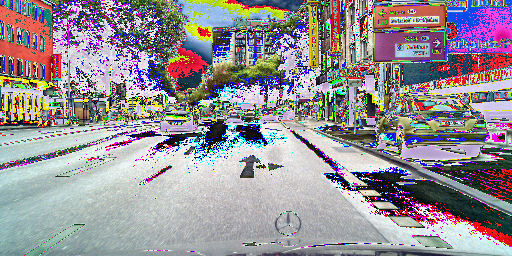

In [22]:
transforms.ToPILImage()(img)

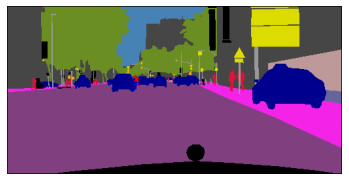

In [23]:
training_data.decode_segmap(label.numpy(), plot=True)

#### Training label ids 
Labels **-1** and **255** shall be ignored.

In [10]:
training_data.label_ids()

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 255]

Check that resizing the label has not created invalid label ids

In [26]:
valid_labels = set(training_data.label_ids())
all_valid = True
for i in range(50):
    j = np.random.randint(0, len(training_data))
    _, lbl = training_data[j]
    if not set(np.unique(lbl.numpy())).issubset(valid_labels):
        print("INVALID LABEL !! > ", np.unique(lbl.numpy()))
        all_valid = False
        
if all_valid:
    print("ALL VALID :D !!")

ALL VALID :D !!


#### Training label colours

In [11]:
training_data.label_colours()

{255: (0, 0, 0),
 0: (128, 64, 128),
 1: (244, 35, 232),
 2: (70, 70, 70),
 3: (102, 102, 156),
 4: (190, 153, 153),
 5: (153, 153, 153),
 6: (250, 170, 30),
 7: (220, 220, 0),
 8: (107, 142, 35),
 9: (152, 251, 152),
 10: (70, 130, 180),
 11: (220, 20, 60),
 12: (255, 0, 0),
 13: (0, 0, 142),
 14: (0, 0, 70),
 15: (0, 60, 100),
 16: (0, 80, 100),
 17: (0, 0, 230),
 18: (119, 11, 32),
 -1: (0, 0, 142)}

#### Training label names

In [12]:
training_data.label_names()

{255: 'unlabeled',
 0: 'road',
 1: 'sidewalk',
 2: 'building',
 3: 'wall',
 4: 'fence',
 5: 'pole',
 6: 'traffic light',
 7: 'traffic sign',
 8: 'vegetation',
 9: 'terrain',
 10: 'sky',
 11: 'person',
 12: 'rider',
 13: 'car',
 14: 'truck',
 15: 'bus',
 16: 'train',
 17: 'motorcycle',
 18: 'bicycle',
 -1: 'license plate'}

#### Mean and standard deviation of the training images

The images are normalized with the mean and the standard deviation of the images that form the training dataset.

In [9]:
training_data.tf

Compose(
    ToTensor()
    Normalize(mean=[0.2869, 0.3251, 0.2839], std=[0.1743, 0.1793, 0.1761])
)

In [16]:
t_mean = []
t_std0 = []

for img, lbl in training_data:
    # shape (3, weight, height)
    numpy_image = img.numpy()
    
    # shape (3,)
    img_mean = np.mean(numpy_image, axis=(1,2)) 
    img_std0 = np.std(numpy_image, axis=(1,2))
    
    t_mean.append(img_mean)
    t_std0.append(img_std0)

# shape (N, 3) -> (mean across 0th axis) -> shape (3,)
t_mean = np.array(t_mean).mean(axis=0)
t_std0 = np.array(t_std0).mean(axis=0)


In [17]:
print("Mean = ", t_mean)

Mean =  [0.28688437 0.32511777 0.28388336]


In [18]:
print("Std. deviation (df = N) = ", t_std0)

Std. deviation (df = N) =  [0.17434599 0.17926791 0.17612955]
